# Spatial Representation Efficiency and Accuracy in ConvNets: Custom Layers and Losses

This is a sub-notebook that validates a number of custom layers, losses, and dataset functions.

For the main thing

### See Also
Main notebook:
* https://github.com/malcolmlett/robovac/blob/main/doc/blog-202506/spatial_representation.ipynb


In [54]:
# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
import os
import sys
#if not os.path.isdir('training-instrumentation-toolkit'):
#  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
#  !cd training-instrumentation-toolkit && git checkout 550ac65
#sys.path.append('training-instrumentation-toolkit')

# Install repo just for this notebook
# (optionally locked to specific git revision so this notebook always works)
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo
sys.path.append('repo/doc/blog-202506')
#!cd repo && git checkout be28234
!cd repo && git pull

# Load custom libraries
import blog_code as blog

# Load standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import tensorflow as tf
from tensorflow.keras import layers
import IPython.display as idisplay
import time
import os
import sys
import math
import tqdm
import cv2
import re

from importlib import reload
reload(blog)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")

HEAD is now at 8dab70b Dataset functions
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 515 bytes | 515.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   8dab70b..a49fb72  main       -> origin/main
Updating 8dab70b..a49fb72
Fast-forward
 doc/blog-202506/blog_code_test.py | 9 ++++++---
 1 file changed, 6 insertions(+), 3 deletions(-)
TensorFlow version: 2.18.0
Keras version: 3.8.0
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [55]:
# run unit tests
import blog_code_test
reload(blog)
reload(blog_code_test)

blog_code_test.run_test_suite()

test_AttentionPool2D (blog_code_test.CustomLayers.test_AttentionPool2D) ... ok
test_CoordGrid (blog_code_test.CustomLayers.test_CoordGrid) ... ok
test_HeatmapPeakCoord (blog_code_test.CustomLayers.test_HeatmapPeakCoord) ... ok
test_PositionwiseMaxPool2D (blog_code_test.CustomLayers.test_PositionwiseMaxPool2D) ... ok
test_heatmap_coordinates_roundtrip (blog_code_test.DataGeneration.test_heatmap_coordinates_roundtrip) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.662s

OK


## Custom Layers

We're going to use a number of custom layers in the models. So in the below we verify what those custom layers do.

**HeatmapPeakCoord**

This layer just wraps the weighted_peak_coordinates() function, which treats the input as a heatmap (or multiple heatmaps if multiple channels) and identifies the (x,y) coordinates of the peak for each heatmap.

Given an input of form (B, H, W, C), it outputs (B, C, 2) as the (x,y) coordinate for each channel.

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 3, 2)
input shape: (1, 149, 149, 1), val range: 0.0 .. 0.25
output shape: (1, 1, 2), value: [[-0.4279866  -0.43040267]], value as pixels: [[10.23      9.870003]]


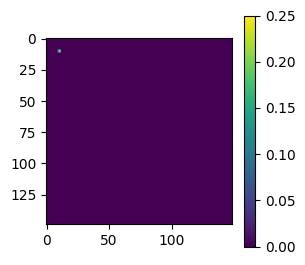

In [29]:
# demo using symbolic tensors
input = tf.keras.Input(shape=(149, 149, 3))
out = blog.HeatmapPeakCoord()(input)
print(f"symbolic output: {type(out)}, shape: {out.shape}")

# demo using real tensors
im = blog.generate_heatmap_image(10.23,9.87)
input = tf.reshape(im, (1, 149, 149, 1))
output = blog.HeatmapPeakCoord()(input)
print(f"input shape: {np.shape(input)}, val range: {np.min(input)} .. {np.max(input)}")
print(f"output shape: {np.shape(output)}, value: {output[0]}, value as pixels: {output[0] * 149 + 149//2}")

plt.figure(figsize=(3,3))
plt.imshow(im)
plt.colorbar()
plt.show()

**CoordGrid**

Takes an input of shape (B, H, W, C), and generates a new tensor of shope (B, H, W, 2) forming the (x,y) grid of coordinates of pixels across the image. Pixel locations are encoded as the fraction of the width/height relative to the image centre, and thus have values in range -0.5 .. +0.5, with (0.0,0.0) at the image centre.

The input is ignored, except for its shape.

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)


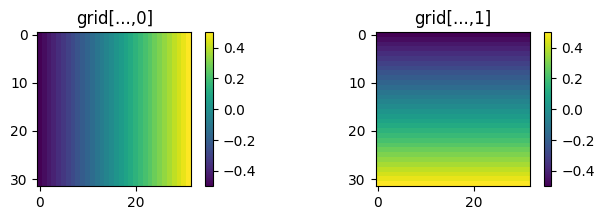

In [36]:
# demo with symbolic tensor
input = tf.keras.Input(shape=(32, 32, 3))
cg = blog.CoordGrid2D()(input)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# demo with concrete tensor
input = tf.zeros((1, 32, 32, 3))
out = blog.CoordGrid2D()(input)
print(f"actual output: {type(out)}, shape: {out.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("grid[...,0]")
plt.imshow(out[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("grid[...,1]")
plt.imshow(out[0,:,:,1])
plt.colorbar()
plt.show()

**StrideGrid**

Similar to CoordGrid, but focused on local pooled patches as inputs to layers like MaxPool.

Takes an input of shape (B, H, W, C), and generates a new tensor of shope (B, H, W, 2) forming the (x,y) grid of coordinates of pixels across the image. The computed positions are relative to the stride window, rather than the global image.

The input is ignored, except for its shape.

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 33, 32, 2)


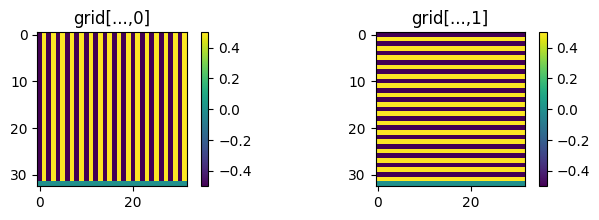

In [ ]:
# demo with symbolic tensor
input = tf.keras.Input(shape=(32, 32, 3))
out = blog.StrideGrid2D()(input)
print(f"symbolic output: {type(out)}, shape: {out.shape}")

# demo with concrete tensor
# - and show how it handles odd numbers of rows
input = tf.zeros((1, 33, 32, 3))
out = blog.StrideGrid2D(strides=2)(input)
print(f"actual output: {type(out)}, shape: {out.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("grid[...,0]")
plt.imshow(out[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("grid[...,1]")
plt.imshow(out[0,:,:,1])
plt.colorbar()
plt.show()

**PositionwiseMaxPool2D**

Inspired by max-pool, however, where max-pool treats each channel separately, this groups all features together for a given 2D position. This in theory allows for more direct transport of spatial information from a CoordGrid2D or StrideGrid2D input.

Pooling operation that selects all channels from the same position as a single unit. Positions are chosen by arg-max over a reduction operation (sum-of-squares).

Use channel_weights to exclude some channels from the reduction.
For example, if the first 32 channels are from semantic features, while the last 2 channels come from a CoordGrid2D input, then given the first 32 channels a weight of 1.0 each, and the last 2 channels a weight of 0.0. This way only the semantic features are arg-maxed over. Otherwise the arg-max operation will be biased towards the position with a larger coordinate value.


actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


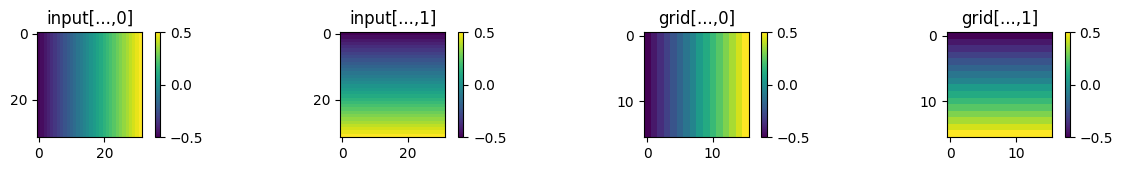

actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


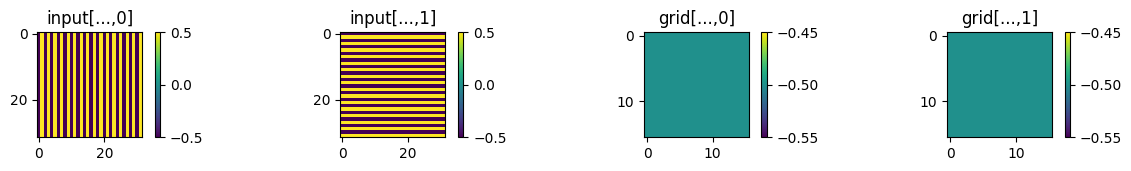

In [38]:
# Demo using CoordGrid2D as input
input = tf.zeros((1, 32, 32, 3))
cg = blog.CoordGrid2D()(input)
mp = blog.PositionwiseMaxPool2D()(cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(15,3))
plt.subplot(2,4,1)
plt.title("input[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,2)
plt.title("input[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()

plt.subplot(2,4,3)
plt.title("grid[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,4)
plt.title("grid[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

# Demo using StrideGrid2D as input
cg = blog.StrideGrid2D()(input)
mp = blog.PositionwiseMaxPool2D()(cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(15,3))
plt.subplot(2,4,5)
plt.title("input[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,6)
plt.title("input[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()

plt.subplot(2,4,7)
plt.title("grid[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,8)
plt.title("grid[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

**AttentionPool2D**

An alternative to MaxPool2D that tries to improve on gradient flow
by using a soft-argmax operation.

2D downsampling layer that computes a soft-argmax from one input to attend to the second input.
Typically used for softmax-weighted pooling of positional inputs, based
on the strength of the feature vectors.

Both inputs must have the same shape (B, H, W, C). Operates channel-wise.
Channels from each input are paired up, in sequence.

Output shape: (B, pooled_H, pooled_W, C).


symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


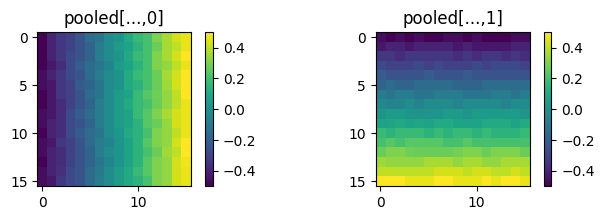

In [39]:
# demo with symbolic tensors
input = tf.keras.Input(shape=(32, 32, 3))
features = blog.StrideGrid2D()(input)
cg = blog.CoordGrid2D()(input)
mp = blog.AttentionPool2D()(features, cg)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# demo with concrete values
input = tf.zeros((1, 32, 32, 3))
cg = blog.CoordGrid2D()(input)
features = tf.random.normal(shape=(1, 32, 32, 2)) * 50
mp = blog.AttentionPool2D()(features, cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("pooled[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("pooled[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

**StridedSoftmax2D & DotPool2D**

These two layers break out the steps of AttentionPool2D for easier interpretability. However, they are limited in their flexibility. They require that stride patches are exactly adjacent and non-overlapping.


symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output (features): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)


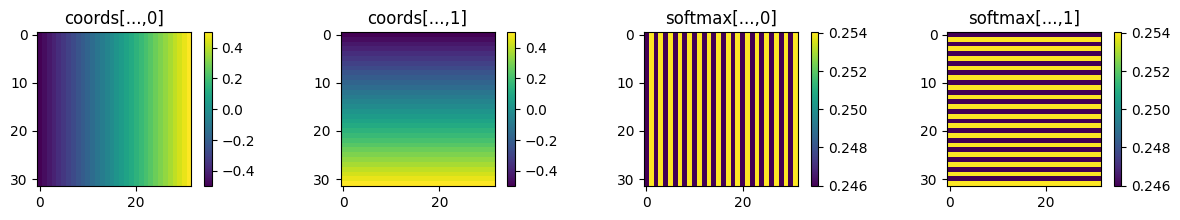

actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


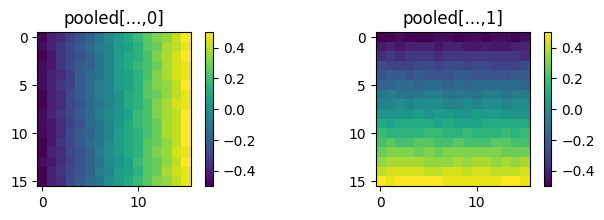

In [42]:
# check with symbolic tensors
input = tf.keras.Input(shape=(32, 32, 3))
features = blog.StrideGrid2D()(input)
cg = blog.CoordGrid2D()(input)
features = blog.StridedSoftmax2D()(features)
mp = blog.DotPool2D()(features, cg)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# check with concrete values -> CoordGrid to StridedSoftmax2D
input = tf.zeros((1, 32, 32, 3))
#coords = tf.random.normal(shape=(1, 8, 8, 2)) * 50
coords = blog.CoordGrid2D()(input)
features = blog.StridedSoftmax2D()(coords)
print(f"actual output (features): {type(features)}, shape: {features.shape}")

plt.figure(figsize=(15,2))
plt.subplot(1,4,1)
plt.title("coords[...,0]")
plt.imshow(coords[0,:,:,0])
plt.colorbar()

plt.subplot(1,4,2)
plt.title("coords[...,1]")
plt.imshow(coords[0,:,:,1])
plt.colorbar()

plt.subplot(1,4,3)
plt.title("softmax[...,0]")
plt.imshow(features[0,:,:,0])
plt.colorbar()

plt.subplot(1,4,4)
plt.title("softmax[...,1]")
plt.imshow(features[0,:,:,1])
plt.colorbar()
plt.show()

# check with concrete values -> CoordGrid + random semantic features to StridedSoftmax + DotPool
input = tf.zeros((1, 32, 32, 3))
cg = blog.CoordGrid2D()(input)
features = tf.random.normal(shape=(1, 32, 32, 2)) * 50
features = blog.StridedSoftmax2D()(features)
mp = blog.DotPool2D()(features, cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("pooled[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("pooled[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

## Test out Layers
One way to verify that the custom-layers are working correctly is to use gradient descent to optimise an input image that results in a particular desired output image after being passed into the custom layer.

This confirms how efficiently backprop gradients can flow through the layer.

For example, a global max-pool supplies backprop gradients only to the single 2D position where the max location is found, for each sample. Thus a global max-pool means that only 32 points are updated for each update step (assuming batch size 32), which is not very efficient.

In [43]:
def optimise_input(model, output, epochs=100, learning_rate=0.1):
  input_shape = model.inputs[0].shape
  input_shape = (1,) + input_shape[1:]

  optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

  input = tf.Variable(tf.random.normal(input_shape), dtype=output.dtype)
  accum_grads = tf.Variable(tf.zeros_like(input))
  print(f"initial input: shape={input.shape}, range={np.min(input)} .. {np.max(input)}")

  display_step = epochs // 10
  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      tape.watch(input)
      output = model(input)
      loss = tf.reduce_mean(tf.square(output - true_output))
    gradients = tape.gradient(loss, input)
    optimizer.apply_gradients(zip([gradients], [input]))
    accum_grads.assign_add(tf.abs(gradients))
    if epoch % display_step == 0 or epoch == epochs-1:
      print(f"Epoch {epoch+1}: loss={loss}, gradients={np.min(gradients)} .. {np.max(gradients)}, input={np.min(input)} .. {np.max(input)}")

  return input.value(), accum_grads.value()

def plot_input_optimisation_old(model, true_output, pred_input, accum_grads):
  pred_output = model(pred_input)

  plt.figure(figsize=(15,3), layout='constrained')

  plt.subplot(2,5,1)
  plt.title("true output")
  vmin, vmax = np.min(true_output), np.max(true_output)
  plt.imshow(true_output[0,...,0], vmin=vmin, vmax=vmax)
  plt.colorbar()
  plt.subplot(2,5,6)
  plt.imshow(true_output[0,...,1], vmin=vmin, vmax=vmax)
  plt.colorbar()

  plt.subplot(2,5,2)
  plt.title("pred input")
  plt.imshow(pred_input[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,7)
  plt.imshow(pred_input[0,...,1])
  plt.colorbar()

  plt.subplot(2,5,3)
  plt.title("accum input grads")
  plt.imshow(accum_grads[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,8)
  plt.imshow(accum_grads[0,...,1])
  plt.colorbar()

  plt.subplot(2,5,4)
  plt.title("pred output")
  plt.imshow(pred_output[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,9)
  plt.imshow(pred_output[0,...,1])
  plt.colorbar()

  plt.subplot(2,5,5)
  plt.title("output error")
  plt.imshow(pred_output[0,...,0] - true_output[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,10)
  plt.imshow(pred_output[0,...,1] - true_output[0,...,1])
  plt.colorbar()

  plt.show()

def plot_input_optimisation(model, true_output, pred_input, accum_grads):
  def _plot_column(cols, col, title, data):
    plt.subplot(2,cols,col)
    plt.title(title)
    vmin, vmax = np.min(data), np.max(data)
    plt.imshow(data[0,...,0], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.subplot(2,cols,cols+col)
    plt.imshow(data[0,...,1], vmin=vmin, vmax=vmax)
    plt.colorbar()

  pred_output = model(pred_input)

  plt.figure(figsize=(15,3), layout='constrained')
  _plot_column(5, 1, "true output", true_output)
  _plot_column(5, 2, "pred input", pred_input)
  _plot_column(5, 3, "accum input grads", accum_grads)
  _plot_column(5, 4, "pred output", pred_output)
  _plot_column(5, 5, "output error", pred_output - true_output)
  plt.show()

**Baselines**

First a baseline, using a few common layers.

true output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 1, 1, 2)
initial input: shape=(1, 32, 32, 2), range=-3.7786290645599365 .. 3.3685591220855713
Epoch 1: loss=8.794329643249512, gradients=0.0 .. 3.3152923583984375, input=-3.7786290645599365 .. 3.1723999977111816
Epoch 51: loss=2.529155731201172, gradients=0.0 .. 2.122744560241699, input=-3.7786290645599365 .. 1.6726107597351074
Epoch 101: loss=1.65141761302948, gradients=0.0 .. 1.767066478729248, input=-3.7786290645599365 .. 1.334316611289978
Epoch 151: loss=1.172417402267456, gradients=0.0 .. 1.5200343132019043, input=-4.19686222076416 .. 1.087580680847168
Epoch 201: loss=0.8791354894638062, gradients=-0.0002753138542175293 .. 1.325998067855835, input=-5.295155048370361 .. 1.4669089317321777
Epoch 251: loss=0.8896349668502808, gradients=0.0 .. 1.1326682567596436, input=-6.133877754211426 .. 0.79784095287323
Epoch 301: loss=0.4833569824695587, gradients=-0.1213483214378357 .. 0.9756990075111389, input=-6.952

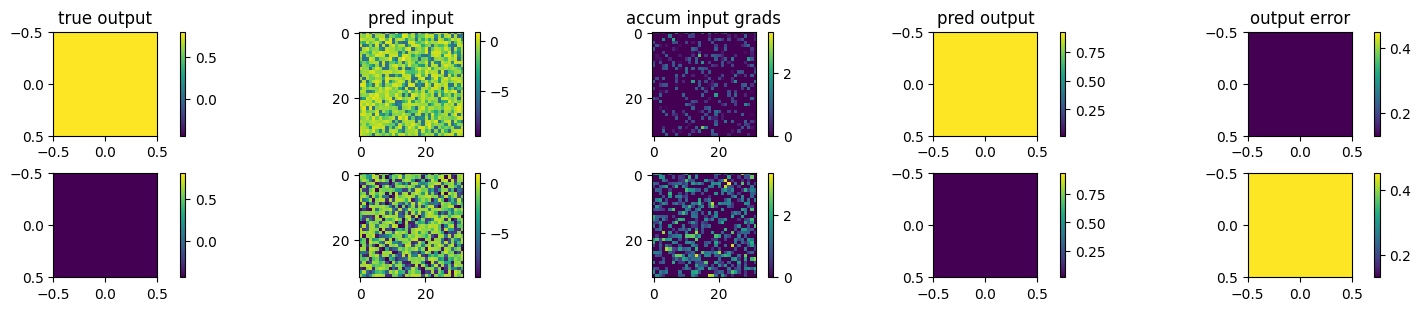

In [44]:
# Optimising input via GlobalMaxPool2D to achieve a single vector output
# - pretty slow and unstable
input = tf.keras.Input(shape=(32, 32, 2))
true_output = tf.constant([[[[0.8, -0.43]]]])
print(f"true output: {type(true_output)}, shape: {true_output.shape}")
features = layers.GlobalMaxPool2D()(input)
features = layers.Reshape(target_shape=(1,1,2))(features)  # for display as an image

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=500, learning_rate=0.5)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.0396485328674316 .. 3.0857932567596436
Epoch 1: loss=1.6556925773620605, gradients=-0.004672273062169552 .. 0.013225754722952843, input=-3.0396485328674316 .. 2.9858179092407227
Epoch 11: loss=0.40222451090812683, gradients=-0.0009832496289163828 .. 0.009367553517222404, input=-3.0396485328674316 .. 2.0021533966064453
Epoch 21: loss=0.08135483413934708, gradients=-0.0010808814549818635 .. 0.00580722838640213, input=-3.0396485328674316 .. 1.1943213939666748
Epoch 31: loss=0.016392724588513374, gradients=-0.0010860192123800516 .. 0.0031783906742930412, input=-3.0396485328674316 .. 0.7319808006286621
Epoch 41: loss=0.00433387141674757, gradients=-0.000952136586420238 .. 0.001458050450310111, input=-3.0396485328674316 .. 0.5995281934738159
Epoch 51: loss=0.0016641516704112291, gradients=-0.0007558956276625395 .. 0.00036489212652668357, input=-3.0396485328674316 .. 0.5493279695510864
Epoch 61: loss=0.0005527751054614782, gradients=-0.00049402122

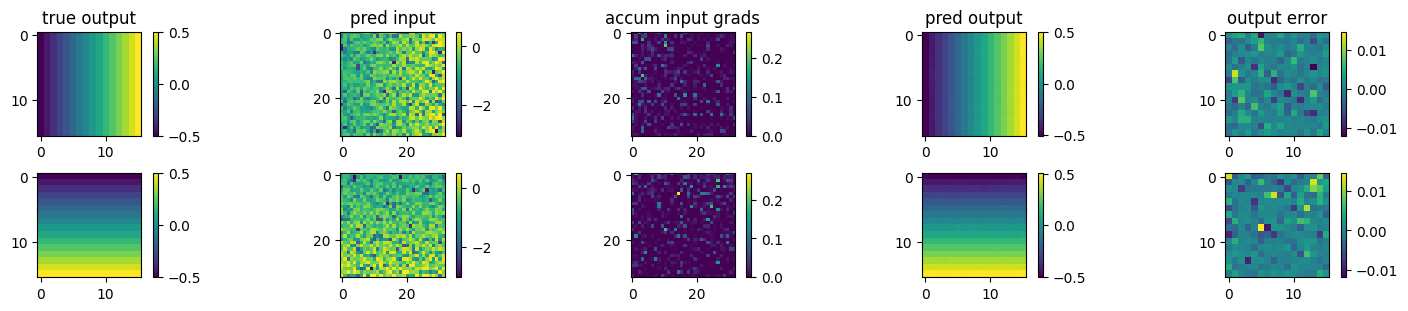

In [45]:
# Optimising input via MaxPool2D to achieve a CoordGrid output
input = tf.keras.Input(shape=(32, 32, 2))
features = layers.MaxPool2D()(input)
true_output = blog.CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.5247292518615723 .. 3.8061838150024414
Epoch 1: loss=0.9104471206665039, gradients=-0.004711580462753773 .. 0.0041290102526545525, input=-3.4248135089874268 .. 3.7062888145446777
Epoch 51: loss=0.007764204405248165, gradients=-0.00019656126096379012 .. 0.00032667393679730594, input=-2.523740768432617 .. 2.52585768699646
Epoch 101: loss=0.0019686161540448666, gradients=-4.602410990628414e-05 .. 4.445919330464676e-05, input=-2.2451510429382324 .. 2.446110486984253
Epoch 151: loss=0.0011071597691625357, gradients=-2.628848233143799e-05 .. 1.981782043003477e-05, input=-1.9156255722045898 .. 3.1630892753601074
Epoch 201: loss=0.0007538419449701905, gradients=-1.6903726645978168e-05 .. 1.2243708624737337e-05, input=-2.0328421592712402 .. 3.823836088180542
Epoch 251: loss=0.0005896804505027831, gradients=-1.0740621291915886e-05 .. 8.348843948624562e-06, input=-2.1586055755615234 .. 4.384193420410156
Epoch 301: loss=0.0005108843906782568, gradients

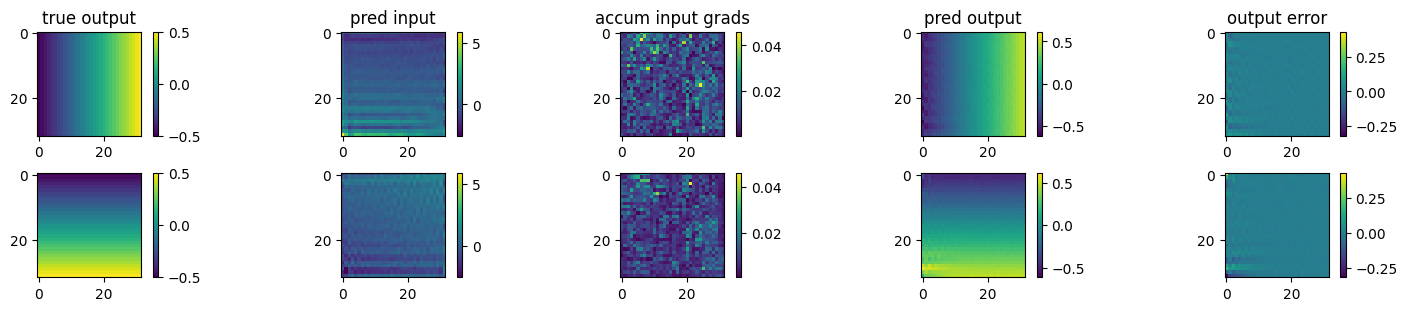

In [46]:
# Optimising input via Conv2D to achieve a CoordGrid output
# - works, but with aliasing and other artifacts
input = tf.keras.Input(shape=(32, 32, 2))
features = layers.Conv2D(filters=2, kernel_size=3, padding='same')(input)
true_output = blog.CoordGrid2D()(tf.zeros((1, 32, 32, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=500)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

Now we'll test our custom layers.

**HeatmapPeakCoord**

Optimising input via HeatmapPeakCoord to achieve a single vector output
- Here you can see how the HeatmapPeakCoord must be used with care.
  When asking it to emit a particular output coordinate it may not be possible to converge.
  Training starts from wherever the first predicted peak is, and only applies gradients
  to the 3x3 grid near that peak. The coordinates are based on the coordinates of those pixels,
  and thus the best it can do is maximise the pixel that's closest to the desired coordinate.


true output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 2, 2)
initial input: shape=(1, 32, 32, 2), range=-3.2633602619171143 .. 3.610269069671631
Epoch 1: loss=0.18091493844985962, gradients=-0.11741849780082703 .. 0.0, input=-3.2633602619171143 .. 3.709868907928467
Epoch 4: loss=0.1389981061220169, gradients=-0.00935068354010582 .. 0.0016825497150421143, input=-3.2633602619171143 .. 3.9536266326904297
Epoch 7: loss=0.13480745255947113, gradients=-0.005419030785560608 .. 0.0020401030778884888, input=-3.2633602619171143 .. 4.091442108154297
Epoch 10: loss=0.13294477760791779, gradients=-0.0040962956845760345 .. 0.001979384571313858, input=-3.2633602619171143 .. 4.133998394012451
Epoch 13: loss=0.13180792331695557, gradients=-0.0034334808588027954 .. 0.00190705806016922, input=-3.2633602619171143 .. 4.102038860321045
Epoch 16: loss=0.13099637627601624, gradients=-0.0030364226549863815 .. 0.0018537212163209915, input=-3.2633602619171143 .. 4.023344039916992
Epoch 19

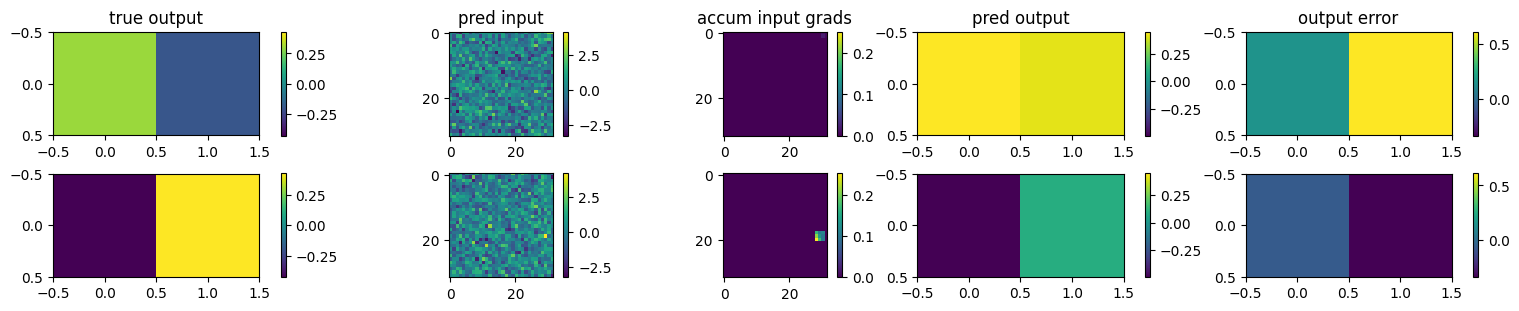

In [47]:
input = tf.keras.Input(shape=(32, 32, 2))
true_output = tf.constant([[[0.3, -0.43], [-0.2, 0.43]]])
print(f"true output: {type(true_output)}, shape: {true_output.shape}")
features = blog.HeatmapPeakCoord()(input)
features = layers.Reshape(target_shape=(1,2,2))(features)  # for display as an image

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=30, learning_rate=0.1)

true_output = tf.reshape(true_output, (1,1,2,2))  # for display as an image
plot_input_optimisation(model, true_output, pred_input, accum_grads)

**PositionwiseMax2D**

Optimising input via PositionwiseMaxPool2D to achieve a CoordGrid output
- This shows how the gradients only take strong effect against the max positions in each 2x2 patch,
  where the remaining 3/4 pixels stay near their initialised state.
  (the max positions might change initially, so that other pixels get some gradients, but it'll be short lived)
- With care, you can also see how it ties the two channels together.


initial input: shape=(1, 32, 32, 2), range=-3.294735908508301 .. 3.0158822536468506
Epoch 1: loss=2.0830271244049072, gradients=-0.01313463132828474 .. 0.013605153188109398, input=-3.194763660430908 .. 2.9159069061279297
Epoch 11: loss=0.7370253205299377, gradients=-0.00888068601489067 .. 0.010061433538794518, input=-2.213881492614746 .. 2.1212165355682373
Epoch 21: loss=0.2426469475030899, gradients=-0.006726113613694906 .. 0.007380778901278973, input=-1.3837809562683105 .. 1.4715248346328735
Epoch 31: loss=0.07098554074764252, gradients=-0.00446220813319087 .. 0.00531347282230854, input=-1.0317752361297607 .. 0.9470129609107971
Epoch 41: loss=0.021779030561447144, gradients=-0.0029025764670222998 .. 0.0030144592747092247, input=-0.7316687703132629 .. 0.782207190990448
Epoch 51: loss=0.009096807800233364, gradients=-0.0013296519173309207 .. 0.0020965044386684895, input=-0.6434812545776367 .. 0.7398191690444946
Epoch 61: loss=0.005050839390605688, gradients=-0.0013973985332995653 .. 0.

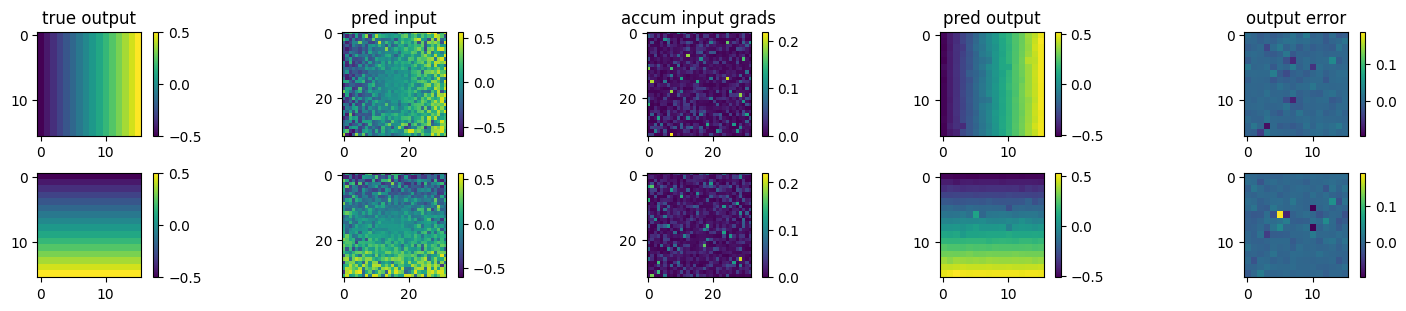

In [48]:
input = tf.keras.Input(shape=(32, 32, 2))
features = blog.PositionwiseMaxPool2D()(input)
true_output = blog.CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

**StridedSoftmax2D**

Optimising input via StridedSoftmax2D to achieve a CoordGrid output
- This produces an initially surprising result: horizontal and vertical bands of approximately equal magnitude. But that is all that it can do, because softmax also performs a normalization, forcing the sum of the patch to 1.0. So it's impossible for it to produce the gradient, and the best it can do is make the correct side of each 2x2 patch higher than the other.


initial input: shape=(1, 32, 32, 2), range=-3.2776505947113037 .. 3.854738473892212
Epoch 1: loss=0.1894964575767517, gradients=-7.846640073694289e-05 .. 0.00012749175948556513, input=-3.024850845336914 .. 3.375732660293579
Epoch 51: loss=0.15111280977725983, gradients=-1.252947095053969e-05 .. 1.7365702660754323e-05, input=-1.1507285833358765 .. 2.935772657394409
Epoch 101: loss=0.15095092356204987, gradients=-6.026925802871119e-06 .. 4.54423070550547e-06, input=-1.1478791236877441 .. 2.4802563190460205
Epoch 151: loss=0.15094955265522003, gradients=-1.5295769628664857e-07 .. 3.502573804325948e-07, input=-1.1451306343078613 .. 2.4836409091949463
Epoch 201: loss=0.15094952285289764, gradients=-2.366159712607896e-08 .. 9.388600119564217e-09, input=-1.1450600624084473 .. 2.482942581176758
Epoch 251: loss=0.15094953775405884, gradients=-1.0993412047355378e-07 .. 1.560266724709436e-07, input=-1.1450532674789429 .. 2.48291015625
Epoch 301: loss=0.15094953775405884, gradients=-4.409719167597

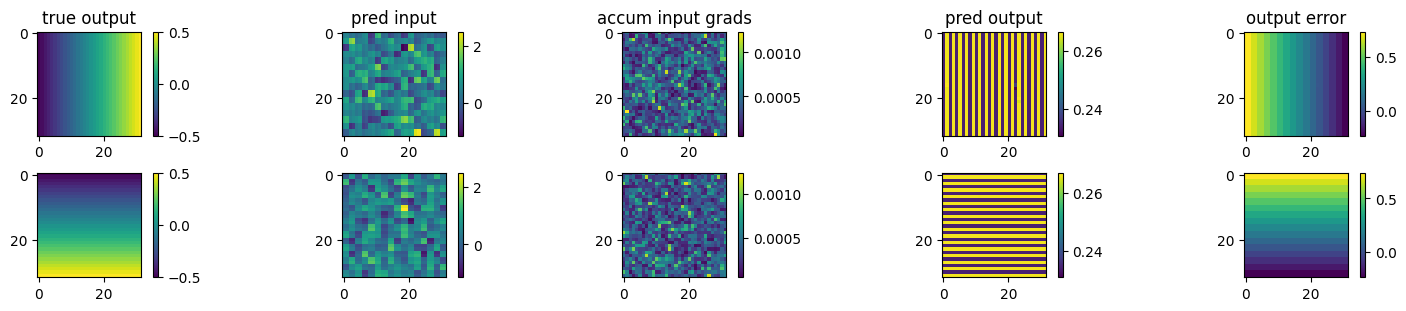

In [49]:
input = tf.keras.Input(shape=(32, 32, 2))
features = blog.StridedSoftmax2D()(input)
true_output = blog.CoordGrid2D()(tf.zeros((1, 32, 32, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=500, learning_rate=0.5)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

**StridedSoftmax2D + DotPool2D**

Optimising input features via StridedSoftmax2D and DotPool2D to achieve a CoordGrid output.
* Seems to basically work.

initial input: shape=(1, 32, 32, 2), range=-3.4783525466918945 .. 3.1630873680114746
Epoch 1: loss=0.00015313969925045967, gradients=-5.772422468908189e-07 .. 5.731341161663295e-07, input=-3.477921962738037 .. 3.1604557037353516
Epoch 11: loss=0.00011949970212299377, gradients=-5.552391257879208e-07 .. 5.170089707462466e-07, input=-3.4673919677734375 .. 3.096931219100952
Epoch 21: loss=7.645987352589145e-05, gradients=-5.30638146756246e-07 .. 5.229954922469915e-07, input=-3.451105833053589 .. 3.147963762283325
Epoch 31: loss=4.216697925585322e-05, gradients=-5.44437341432058e-07 .. 5.085939278615115e-07, input=-3.433962106704712 .. 3.207249879837036
Epoch 41: loss=2.1346726498450153e-05, gradients=-4.5408600612972805e-07 .. 5.386962698139541e-07, input=-3.420872926712036 .. 3.26544189453125
Epoch 51: loss=1.085360418073833e-05, gradients=-3.269551882567612e-07 .. 3.3621279271756066e-07, input=-3.4132728576660156 .. 3.3192124366760254
Epoch 61: loss=5.994473212922458e-06, gradients=-2.1

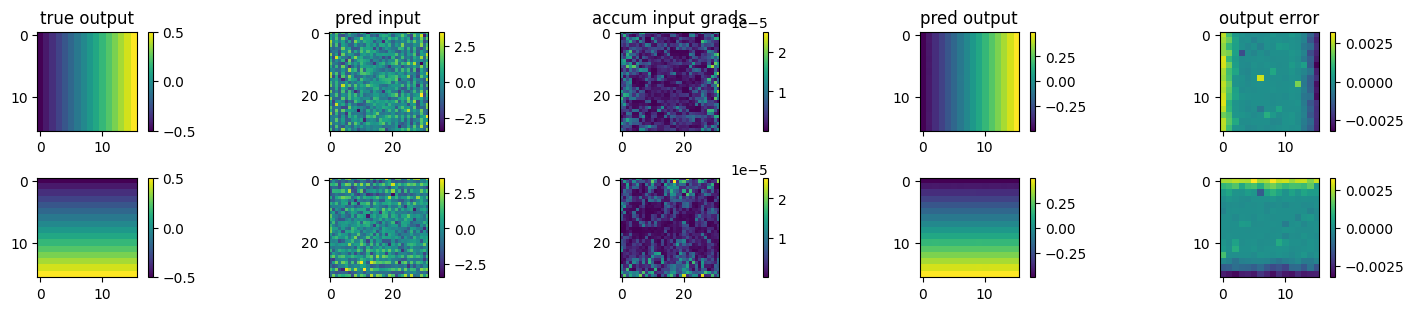

In [50]:
input = tf.keras.Input(shape=(32, 32, 2))
features = blog.StridedSoftmax2D()(input)
features = blog.DotPool2D()(features, blog.CoordGrid2D()(input))
true_output = blog.CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=100, learning_rate=0.1)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

**AttentionPool2D**

Optimising input features via AttentionPool2D to achieve a CoordGrid output
- Notice that the appearance of the optimised input here looks the same as when using StridedSoftmax2D and DotPool2D, confirming that they're both doing the same thing.


initial input: shape=(1, 32, 32, 2), range=-3.4999840259552 .. 3.887833833694458
Epoch 1: loss=0.00015176113811321557, gradients=-5.500156703419634e-07 .. 5.73819988858304e-07, input=-3.499990463256836 .. 3.885343551635742
Epoch 11: loss=0.00012035052350256592, gradients=-5.184815563552547e-07 .. 5.397917561822396e-07, input=-3.5001473426818848 .. 3.824859142303467
Epoch 21: loss=7.989796722540632e-05, gradients=-5.51225070921646e-07 .. 5.581326831816114e-07, input=-3.500380516052246 .. 3.7234878540039062
Epoch 31: loss=4.6707369619980454e-05, gradients=-4.926811811856169e-07 .. 5.350647711566126e-07, input=-3.5006322860717773 .. 3.5838544368743896
Epoch 41: loss=2.487159872543998e-05, gradients=-5.285150450617948e-07 .. 5.357213694878737e-07, input=-3.5008671283721924 .. 3.396578788757324
Epoch 51: loss=1.240104938915465e-05, gradients=-4.042660748382332e-07 .. 3.3222752904293884e-07, input=-3.5010621547698975 .. 3.218019723892212
Epoch 61: loss=6.455860329879215e-06, gradients=-2.754

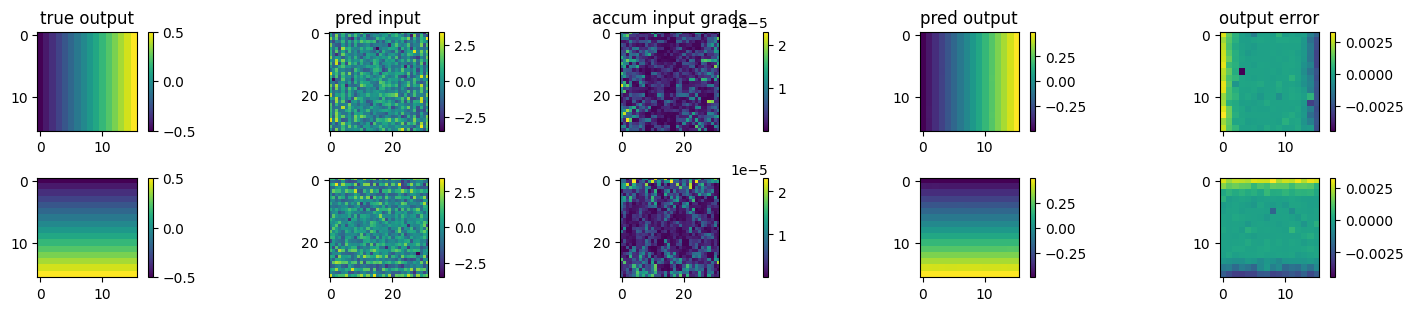

In [51]:
input = tf.keras.Input(shape=(32, 32, 2))
features = blog.AttentionPool2D()(input, blog.CoordGrid2D()(input))
true_output = blog.CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=100, learning_rate=0.1)

plot_input_optimisation(model, true_output, pred_input, accum_grads)